<a href="https://colab.research.google.com/github/bcaffo/ds4bme_intro/blob/master/notebooks/logisticRegression_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an extension of using pytorch to perform linear regression to using it to perform logistic regression.

In [113]:
import pandas as pd
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read in the data and display a few rows
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")
dat.head(4)

## Create a binary outcome variable (people will use gold lesions in HW)
m = np.median(dat.T2)
dat = dat.assign(y = (dat.T2 > m) * 1 )
## Create a normalized regression variable
dat = dat.assign(x = (dat.PD - np.mean(dat.PD)) / np.std(dat.PD))
dat.head()


,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions,y,x
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0,1,1.181648
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0,1,1.426453
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0,0,-0.614749
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0,0,-0.955175
4,1.580589,1.730152,-0.860949,1.245609,0.617957,0.866352,-0.099919,0.384261,0.391133,0.608826,0.071648,0.340601,0,1,1.376909


In [114]:
fit = smf.logit('y ~ x', data = dat).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.427855
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 Sep 2020   Pseudo R-squ.:                  0.3827
Time:                        02:50:12   Log-Likelihood:                -42.785
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 3.238e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0367      0.269      0.136      0.892      -0.491       0.565
x              2.2226      0.436      5.095      0.000       1.368       3.078
==============================================================================
"""

In [115]:
# The in sample predictions
yhat = 1 / (1 + np.exp(-fit.fittedvalues))

In [116]:
n = dat.shape[0]

## Get the y and x from 
xtraining = torch.from_numpy(dat['x'].values)
ytraining = torch.from_numpy(dat['y'].values)

## PT wants floats
xtraining = xtraining.float()
ytraining = ytraining.float()

## Dimension is 1xn not nx1
## squeeze the second dimension
xtraining = xtraining.unsqueeze(1)
ytraining = ytraining.unsqueeze(1)

## Show that everything is the right size
[xtraining.shape, 
 ytraining.shape,
 [n, 1]
 ]



[torch.Size([100, 1]), torch.Size([100, 1]), [100, 1]]

In [117]:
## Doing it more now the pytorch docs recommend
## Example taken from 
## https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9

## They recommend creating a class that defines
## the model
class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias = True)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

## Then the model is simply  
model = LogisticRegression()

## MSE is the loss function
loss_fn = torch.nn.BCELoss()  

## Set the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

## Loop over iterations
for t in range(100000):

  ## Forward propagation
  y_pred = model(xtraining)

  ## the loss for this interation
  loss = loss_fn(y_pred, ytraining)

  #print(t, loss.item() / n)

  ## Zero out the gradients before adding them up 
  optimizer.zero_grad()
  
  ## Backprop
  loss.backward()
  
  ## Optimization step
  optimizer.step()



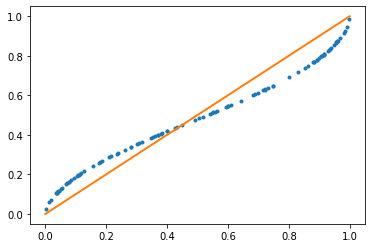

In [118]:
ytest = model(xtraining)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest,  ".")
plt.plot([0, 1], [0, 1], linewidth=2)

In [119]:
for param in model.parameters():  
  print(param.data)


tensor([[1.4062]])
tensor([-0.0502])
